# Modeling Catalina QSO light curves with an Auto encoder model

Brett et al. 2017 applied the auto-encoder model to 50,124 light curves from the All Sky Automated Survey (ASAS) Catalog of Variable stars and then got auto-encoded features which can be used for the classification of variable stars. 
The classification with the auto-encoded features shows the comparable or sometimes outperform the human-made features. 

Then our motivation is obtaining useful features of the QSO light curves and modeling/forecasting it with the auto-encoder model. 
In this notebook I have checked the performance and the result with very preliminary auto-encoder structure. 

For constructing the auto-encoder I used keras in this time. 

In [1]:
import sys
sys.path.append('./IrregularTimeSeriesAutoencoder')
import numpy as np
import pandas as pd
from keras.layers import (Input, Dense, TimeDistributed, LSTM, GRU, Dropout, merge,
                          Flatten, RepeatVector, Recurrent, Bidirectional, SimpleRNN)
from keras.models import Model
import keras_util as ku
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display_png, display_pdf

Using TensorFlow backend.


I used 'keras_util' (https://github.com/bnaul/IrregularTimeSeriesAutoencoderPaper) and structure of the encoder/decoder described in there.

The architecture shown in Brett et al. (2017). 

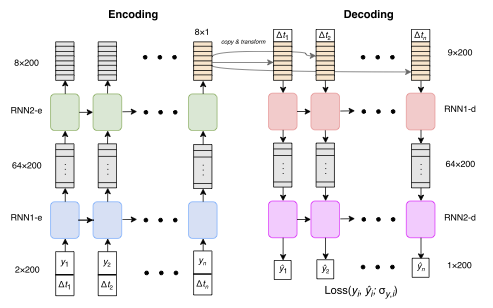

In [247]:
display_png(Image('./Auto_Encoder.png'))

### Encoder

In [2]:
def encoder(model_input, layer, size, num_layers, drop_frac=0.25, output_size=None,
            bidirectional=False, **parsed_args):
    if output_size is None:
        output_size = size
    encode = model_input
    for i in range(num_layers):
        wrapper = Bidirectional if bidirectional else lambda x: x
        encode = wrapper(layer(size, name='encode_{}'.format(i),
                               return_sequences=(i < num_layers - 1)))(encode)
        if drop_frac > 0.0:
            encode = Dropout(drop_frac, name='drop_encode_{}'.format(i))(encode)
    encode = Dense(output_size, activation='linear', name='encoding')(encode)
    return encode

###########################
print(
    """Encoder module of autoencoder architecture.

    Can be used either as the encoding component of an autoencoder or as a standalone
    encoder, which takes (possibly irregularly-sampled) time series as inputs and produces
    a fixed-length vector as output.

    model_input: `keras.layers.Input`
        Input layer containing (y) or (dt, y) values
    layer: `keras.layers.Recurrent`
        Desired `keras` recurrent layer class
    size: int
        Number of units within each hidden layer
    num_layers: int
        Number of hidden layers
    drop_frac: float
        Dropout rate
    output_size: int, optional
        Size of encoding layer; defaults to `size`
    bidirectional: bool, optional
        Whether the bidirectional version of `layer` should be used; defaults to `False`
    """
)
###########################

Encoder module of autoencoder architecture.

    Can be used either as the encoding component of an autoencoder or as a standalone
    encoder, which takes (possibly irregularly-sampled) time series as inputs and produces
    a fixed-length vector as output.

    model_input: `keras.layers.Input`
        Input layer containing (y) or (dt, y) values
    layer: `keras.layers.Recurrent`
        Desired `keras` recurrent layer class
    size: int
        Number of units within each hidden layer
    num_layers: int
        Number of hidden layers
    drop_frac: float
        Dropout rate
    output_size: int, optional
        Size of encoding layer; defaults to `size`
    bidirectional: bool, optional
        Whether the bidirectional version of `layer` should be used; defaults to `False`
    


### Decoder

In [3]:
def decoder(encode, layer, n_step, size, num_layers, drop_frac=0.25, aux_input=None,
            bidirectional=False, **parsed_args):
    
    decode = RepeatVector(n_step, name='repeat')(encode)
    if aux_input is not None:
        decode = merge([aux_input, decode], mode='concat')

    for i in range(num_layers):
        if drop_frac > 0.0 and i > 0:  # skip these for first layer for symmetry
            decode = Dropout(drop_frac, name='drop_decode_{}'.format(i))(decode)
        wrapper = Bidirectional if bidirectional else lambda x: x
        decode = wrapper(layer(size, name='decode_{}'.format(i),
                               return_sequences=True))(decode)

    decode = TimeDistributed(Dense(1, activation='linear'), name='time_dist')(decode)
    return decode

###########################
print(
    """Decoder module of autoencoder architecture.

    Can be used either as the decoding component of an autoencoder or as a standalone
    decoder, which takes a fixed-length input vector and generates a length-`n_step`
    time series as output.

    layer: `keras.layers.Recurrent`
        Desired `keras` recurrent layer class
    n_step: int
        Length of output time series
    size: int
        Number of units within each hidden layer
    num_layers: int
        Number of hidden layers
    drop_frac: float
        Dropout rate
    aux_input: `keras.layers.Input`, optional
        Input layer containing `dt` values; if `None` then the sequence is assumed to be
        evenly-sampled
    bidirectional: bool, optional
        Whether the bidirectional version of `layer` should be used; defaults to `False`
    """
)
###########################

Decoder module of autoencoder architecture.

    Can be used either as the decoding component of an autoencoder or as a standalone
    decoder, which takes a fixed-length input vector and generates a length-`n_step`
    time series as output.

    layer: `keras.layers.Recurrent`
        Desired `keras` recurrent layer class
    n_step: int
        Length of output time series
    size: int
        Number of units within each hidden layer
    num_layers: int
        Number of hidden layers
    drop_frac: float
        Dropout rate
    aux_input: `keras.layers.Input`, optional
        Input layer containing `dt` values; if `None` then the sequence is assumed to be
        evenly-sampled
    bidirectional: bool, optional
        Whether the bidirectional version of `layer` should be used; defaults to `False`
    


### Loading Catalina light curves

In [4]:
import subprocess
def load_lcs(pass_to_lc_dir):
    command = 'ls ' + str(pass_to_lc_dir)
    lc_files = subprocess.run(command, stdout=subprocess.PIPE, shell=True).stdout.decode('utf-8').split('\n')
    del lc_files[len(lc_files)-1]
    print('Loading %d data:'%len(lc_files))
    X = [np.r_[np.array(pd.read_csv('./lcs/'+str(lc_files[i]), header=None, sep=' ')).tolist()] for i in range(len(lc_files))]
    print('Finish.')
    return  X

In [19]:
X_list = load_lcs('./lcs/')

Loading 4227 data:
Finish.


Example of the loaded data: [MJD, MAG, ERR]

In [21]:
X_list[0][0:3]

array([[  5.35634411e+04,   1.89311076e+01,   1.12301811e-01],
       [  5.36272669e+04,   1.86228614e+01,   1.13120127e-01],
       [  5.36363174e+04,   1.89534407e+01,   1.11743680e-01]])

Randomize the order of the list for avoiding the systematic effect of the index of the data. 

In [23]:
np.random.shuffle(X_list)
X_list[0][0:3]

array([[  5.34642160e+04,   1.81742509e+01,   6.53732766e-02],
       [  5.34811906e+04,   1.79577590e+01,   9.73836324e-02],
       [  5.34941461e+04,   1.80139406e+01,   6.02745120e-02]])

In [24]:
from keras.preprocessing.sequence import pad_sequences
X_raw = pad_sequences(X_list, value=np.nan, dtype='float', padding='post')

### Preprocess for the input data: 

MJD -> $\Delta$MJD

mag -> [mag - mean(mag)]/std(mag)

In [25]:
def preprocess(X_raw, m_max=np.inf):
    X = X_raw.copy()
    wrong_units =  np.all(np.isnan(X[:, :, 1])) | (np.nanmax(X[:, :, 1], axis=1) > m_max)
    X = X[~wrong_units, :, :]
    X[:, :, 0] = ku.times_to_lags(X[:, :, 0])
    means = np.atleast_2d(np.nanmean(X[:, :, 1], axis=1)).T
    X[:, :, 1] -= means
    scales = np.atleast_2d(np.nanstd(X[:, :, 1], axis=1)).T
    X[:, :, 1] /= scales
    errors = X[:, :, 2] / scales
    X = X[:, :, :2]
    return X, means, scales, errors, wrong_units

In [26]:
X, means, scales, errors, wrong_units = preprocess(X_raw)
main_input = Input(shape=(X.shape[1], 2), name='main_input') #(lag, mag)
aux_input = Input(shape=(X.shape[1], 1), name='aux_input') #(lag)
model_input = [main_input, aux_input]

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


w = 1/err, loss = [w(y-y$_{\rm pred}$)]$^2$ (reduced $\chi$ squre)

In [27]:
sample_weight = 1. / errors
sample_weight[np.isnan(sample_weight)] = 0.0
X[np.isnan(X)] = 0.

Encoder

    RNN: GRU

    Number of units within each hidden layer: 64

    Number of hidden layers: 5

    Size of encoding layer=64

    Dropout rate = 0.25 

    bidirectional version of 'layer' is used
    
Decoder

    RNN: GRU

    Number of units within each hidden layer: 64

    Number of hidden layers: 5

    Size of encoding layer=64

    Dropout rate = 0.25 

In [28]:
encode = encoder(main_input, layer=GRU, size=64, num_layers=5, output_size=64, drop_frac=0.25, bidirectional=True)
decode = decoder(encode, layer=GRU, size=64, num_layers=5,  n_step=X.shape[1], drop_frac=0.25, aux_input=aux_input)
model = Model(model_input, decode)

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [29]:
lr = 1e-3 #learning rate 

In [30]:
from keras.optimizers import Adam
import os

optimizer = Adam(lr=lr)

log_dir = os.path.join(os.getcwd(), 'keras_logs', 'test')
log_dir += "_ft{:1.0e}".format(lr).replace('e-', 'm')
weights_path = os.path.join(log_dir, 'weights.h5')

print("""log directory: {0} \n
weight pass: {1} """.format(log_dir, weights_path))

log directory: /Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03 

weight pass: /Users/y_tachibana/Documents/AutoEncoder/keras_logs/test_ft1m03/weights.h5 


In [33]:
#model.load_weights(weights_path)
model.compile(optimizer=optimizer, loss='mse',  sample_weight_mode='temporal')

In [34]:
import shutil
shutil.rmtree(log_dir, ignore_errors=True)
os.makedirs(log_dir)

In [35]:
from keras.callbacks import (Callback, TensorBoard, EarlyStopping,
                             ModelCheckpoint, CSVLogger, ProgbarLogger)
from keras_tqdm import TQDMCallback
import sys
import csv
from collections import Iterable, OrderedDict
import datetime

class Progbar(TQDMCallback):  # redirect TQDMCallback to stdout
    def __init__(self):
        TQDMCallback.__init__(self)
        self.output_file = sys.stdout
class TimedCSVLogger(CSVLogger):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        def handle_value(k):
            is_zero_dim_ndarray = isinstance(k, np.ndarray) and k.ndim == 0
            if isinstance(k, Iterable) and not is_zero_dim_ndarray:
                return '"[%s]"' % (', '.join(map(str, k)))
            else:
                return k

        if not self.writer:
            self.keys = sorted(logs.keys())

            class CustomDialect(csv.excel):
                delimiter = self.sep

            self.writer = csv.DictWriter(self.csv_file,
                                         fieldnames=['epoch', 'time'] + self.keys,
                                         dialect=CustomDialect)
            if self.append_header:
                self.writer.writeheader()

        row_dict = OrderedDict({'epoch': epoch, 'time': str(datetime.datetime.now())})
        row_dict.update((key, handle_value(logs[key])) for key in self.keys)
        self.writer.writerow(row_dict)
        self.csv_file.flush()
class LogDirLogger(Callback):
    def __init__(self, log_dir):
        self.log_dir = log_dir 

    def on_epoch_begin(self, epoch, logs=None):
        print('\n' + self.log_dir + '\n')

In [1]:
"""
history = model.fit({'main_input': X, 'aux_input': np.delete(X, 1, axis=2)},
                    X[:, :, [1]], 
                    nb_epoch=1024, 
                    batch_size=256,
                    sample_weight=sample_weight,
                    callbacks=[Progbar(),
                           TensorBoard(log_dir=log_dir, write_graph=False),
                           TimedCSVLogger(os.path.join(log_dir, 'training.csv'), append=True),
                           ModelCheckpoint(weights_path, save_weights_only=True),
                           LogDirLogger(log_dir)], 
                    verbose=False,
                    validation_split=0.2,
                    validation_data=None)
"""

"\nhistory = model.fit({'main_input': X, 'aux_input': np.delete(X, 1, axis=2)},\n                    X[:, :, [1]], \n                    nb_epoch=1024, \n                    batch_size=256,\n                    sample_weight=sample_weight,\n                    callbacks=[Progbar(),\n                           TensorBoard(log_dir=log_dir, write_graph=False),\n                           TimedCSVLogger(os.path.join(log_dir, 'training.csv'), append=True),\n                           ModelCheckpoint(weights_path, save_weights_only=True),\n                           LogDirLogger(log_dir)], \n                    verbose=False,\n                    validation_split=0.2,\n                    validation_data=None)\n"

In [32]:
import glob

def parse_logs(log_files, max_epoch=1000):
    logs = [pd.read_csv(f, index_col='epoch', parse_dates=[1]) for f in log_files]
    for log, f in zip(logs, log_files):
        run = f.split('/')[-2]
        log.drop(log.index[log.index > max_epoch], axis=0, inplace=True)
        if 'time' not in log:
            raise ValueError("Missing times from {}".format(f))
        log.columns = ['time', run + ' Train', run + ' Valid']
        log['time'] = log['time'].values.astype(float)
        log['time'] = (log['time'] - log['time'].min()) / 1e9
    step_logs = pd.concat([l.drop('time', axis=1, inplace=False) for l in logs], axis=1)
    time_logs = pd.concat([l.set_index('time') for l in logs], axis=1)
    
    return step_logs, time_logs

In [37]:
train = pd.read_csv('./keras_logs/test_ft1m03/training.csv')

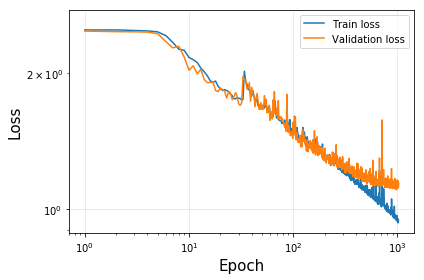

In [60]:
plt.plot(train.epoch, train.loss, label='Train loss')
plt.plot(train.epoch, train.val_loss, label='Validation loss')
plt.yscale('log'); plt.xscale('log')
plt.xlabel('Epoch', fontsize=15); plt.ylabel('Loss', fontsize=15)
plt.legend(loc='best')
plt.grid(lw=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

Loading trained weight and compiling the model

In [39]:
model.load_weights(weights_path)
model.compile(optimizer=optimizer, loss='mse',  sample_weight_mode='temporal')

Getting the encoded features and the decoded light curves

In [40]:
encode_model = Model(input=model.input, output=model.get_layer('encoding').output)
decode_model = Model(input=model.input, output=model.output)
encoding = encode_model.predict({'main_input': X, 'aux_input': np.delete(X, 1, axis=2)})
decoding = decode_model.predict({'main_input': X, 'aux_input': np.delete(X, 1, axis=2)})

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("en...)`
  """Entry point for launching an IPython kernel.
/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ti...)`
  


In [41]:
encoding_train = encoding[0:int(0.8*len(X_list))]
encoding_val = encoding[int(0.8*len(X_list)):len(X_list)]
decoding_train = decoding[0:int(0.8*len(X_list))]
decoding_val = decoding[int(0.8*len(X_list)):len(X_list)]
X_raw_train = X_raw[0:int(0.8*len(X_list))]
X_raw_val = X_raw[int(0.8*len(X_list)):len(X_list)]
X_train = X[0:int(0.8*len(X_list))]
X_val = X[int(0.8*len(X_list)):len(X_list)]
scales_train = scales[0:int(0.8*len(X_list))]
scales_val = scales[int(0.8*len(X_list)):len(X_list)]
means_train = means[0:int(0.8*len(X_list))]
means_val = means[int(0.8*len(X_list)):len(X_list)]

### Examples of modeled light curves and encoded features of the training set

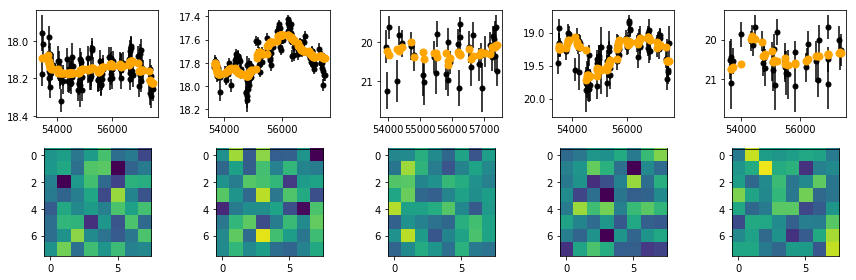

Upper panels: Input light curves (black points) and decoded light curves (orange points) 

Lower panels: Encoded 16 features


In [45]:
i = 0 #init num of the plotting data
k=0 #initialize the counter
fignum = 5
plt.figure(figsize=(12, 4))
#plotting raw-lightcurves and the decoded lightcurves 
for num in range(i,i+fignum):
    plt.subplot(2, fignum, k+1)
    plt.errorbar(X_raw_train[num][:,0], X_raw_train[num][:,1], yerr=X_raw_train[num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(np.cumsum(X_train[num][:, 0][X_train[num][:, 0]>0])+X_raw_train[num][0,0], 
             decoding_train[num][X_train[num][:, 0]>0]*scales_train[num]+means_train[num], fmt='o', color='orange', ms=7)
    plt.ylim(plt.ylim()[::-1])
    k += 1
#plotting encoded features
k=0
for num in range(i+fignum,i+2*fignum):
    plt.subplot(2, fignum, k+1+fignum)
    plt.imshow(encoding_train[num].reshape(8,8), vmin=-2, vmax=2, cmap='viridis_r')
    k += 1
plt.tight_layout()
plt.savefig('Catalina_modeled_lc_encoded_features_train.pdf', pad_inches=0.5)
plt.show()

print("""Upper panels: Input light curves (black points) and decoded light curves (orange points) \n
Lower panels: Encoded 16 features""")

### Examples of modeled light curves and encoded features of the validation set

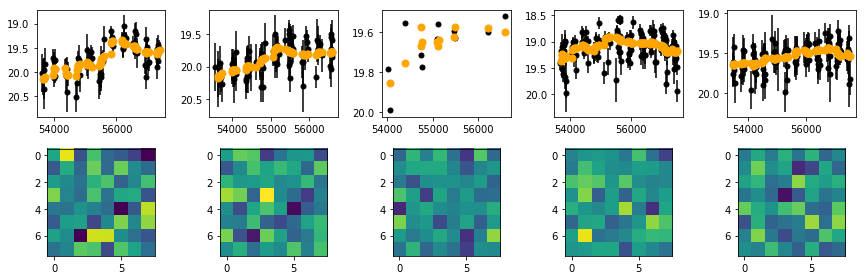

In [48]:
i = 0 #init num of the plotting data
k=0 #initialize the counter
fignum = 5
plt.figure(figsize=(12, 4))
#plotting raw-lightcurves and the decoded lightcurves 
for num in range(i,i+fignum):
    plt.subplot(2, fignum, k+1)
    plt.errorbar(X_raw_val[num][:,0], X_raw_val[num][:,1], yerr=X_raw_val[num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], 
             decoding_val[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num], fmt='o', color='orange', ms=7)
    plt.ylim(plt.ylim()[::-1])
    k += 1
#plotting encoded features
k=0
for num in range(i+fignum,i+2*fignum):
    plt.subplot(2, fignum, k+1+fignum)
    plt.imshow(encoding_val[num].reshape(8,8), vmin=-2, vmax=2, cmap='viridis_r')
    k += 1
plt.tight_layout()
plt.savefig('Catalina_modeled_lc_encoded_features_val.pdf', pad_inches=0.5)
plt.show()


### Distribution of the reduced chi-square

In [49]:
def calc_redchisq(x, x_pred, weight):
    mask =  (~np.isnan(weight))
    out = np.sum(((x[mask]-x_pred[mask])*weight[mask])**2)/len(weight[mask])
    return out

RedChiSq = []
print('Caluculating reduced chi-square for each source')
for m in range(0, len(X_raw)):
    if m%100 == 0:
        print('.', end='')
    RedChiSq.append(calc_redchisq(X[m][:,1]*scales[m]+means[m], np.squeeze(decoding[m]*scales[m]+means[m]), 1/X_raw[m][:,2]))

Caluculating reduced chi-square for each source
...........................................

In [50]:
RedChiSq_train = RedChiSq[0:int(0.8*len(X_list))]
RedChiSq_val = RedChiSq[int(0.8*len(X_list)):len(X_list)]

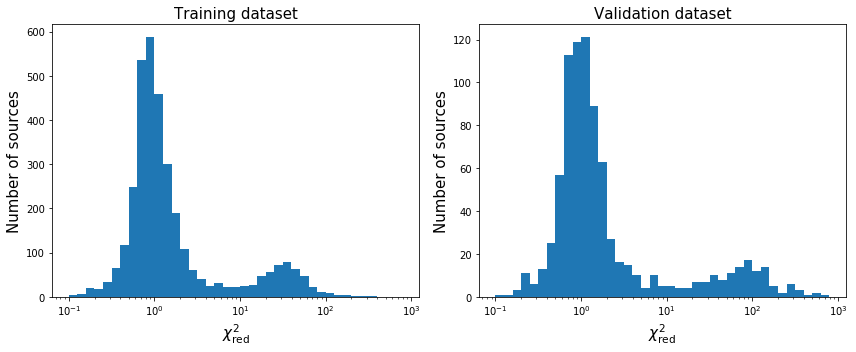

In [79]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(np.array(RedChiSq_train)[~np.isnan(RedChiSq_train)], 
         bins=10**np.arange(-1, 3, 0.1))
plt.xscale('log')
plt.xlabel(r'$\chi_{{\rm red}}^2$', fontsize=15)
plt.ylabel('Number of sources', fontsize=15)
plt.title('Training dataset', fontsize=15)
plt.tight_layout()
plt.savefig('Catalina_chi_hist.pdf', pad_inches=0.5)

plt.subplot(1,2,2)
plt.hist(np.array(RedChiSq_val)[~np.isnan(RedChiSq_val)], 
         bins=10**np.arange(-1, 3, 0.1))
plt.xscale('log')
plt.xlabel(r'$\chi_{{\rm red}}^2$', fontsize=15)
plt.ylabel('Number of sources', fontsize=15)
plt.title('Validation dataset', fontsize=15)
plt.tight_layout()
plt.savefig('Catalina_chi_hist.pdf', pad_inches=0.5)

plt.tight_layout()
plt.show()

The distribution of the validation dataset shows two peaks. What does this mean??

### Visualizing the distribution of the encoded features by t-SNE

In [52]:
from sklearn.manifold import TSNE

In [53]:
X_reduced_train =TSNE(n_components=2, perplexity=100, random_state=32, n_iter=1000).fit_transform(encoding_train)

In [55]:
import statsmodels.nonparametric.api as smnp
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import seaborn as sns
from matplotlib import gridspec as grs
from scipy import stats

def kde_contour_dat(x, y, extent = 'Auto', bw_type = "silverman", grid_bins = 200, BW=False):
    """Determine normalized KDE PDF to draw contours"""
    
    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(y, pd.Series):
        y = y.values
    
    if extent == 'Auto':
        extent = (x.min(), x.max(), y.min(), y.max())

    if bw_type == "silverman":
        bw = np.array([smnp.bandwidths.bw_silverman(x), smnp.bandwidths.bw_silverman(y)])
    elif bw_type == "scott":
        bw = np.array([smnp.bandwidths.bw_scott(x), smnp.bandwidths.bw_scott(y)])
    if BW:
        bw = BW

    kde = KDEMultivariate([x,y], var_type='cc', bw = bw)

    xi, yi = np.mgrid[extent[0]:extent[1]:grid_bins*1j,extent[2]:extent[3]:grid_bins*1j]

    kde_prob = kde.pdf(np.vstack([xi.flatten(), yi.flatten()]))

    zi = (kde_prob-kde_prob.min())/(kde_prob.max() - kde_prob.min())
    zi = zi.reshape(xi.shape)

    return xi, yi, zi

In [56]:
rx, ry, rz = kde_contour_dat(X_reduced_train[:, 0], X_reduced_train[:, 1], grid_bins=100, BW=[2,2], extent=[-50, 50, -50, 50])

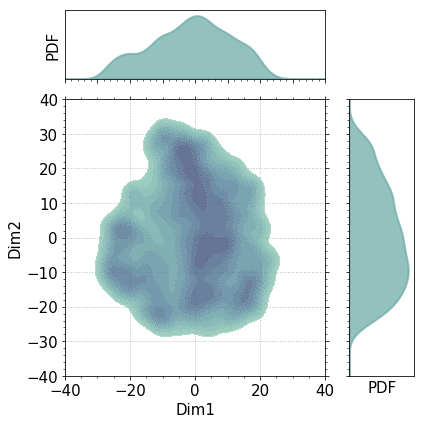

In [332]:
X, Y = X_reduced_train[:, 0], X_reduced_train[:, 1]

xlims = [-40, 40]
ylims = [-40, 40]

origin = 'lower'
levels = np.arange(0.1, 1.1, 0.1)
cmap = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

gs = grs.GridSpec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4))
plt.figure(figsize=(6, 6))
ax = [plt.subplot(gs[1, 0]), plt.subplot(gs[1, 1]), plt.subplot(gs[0, 0]), plt.subplot(gs[0,1])]

ax[0].grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
ax[0].tick_params(which="both", top=True, right=True)
ax[0].minorticks_on()
ax[0].set_axisbelow(True)
ax[0].contourf(rx, ry, rz, levels = levels,
             origin = origin,
             cmap = cmap, alpha = 0.8)
ax[0].contour(rx, ry, rz, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)
ax[0].set_xlim(xlims); ax[0].set_ylim(ylims)
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('Dim1', fontsize=15)
ax[0].set_ylabel('Dim2', fontsize=15)

n = (np.linspace(ylims[0]-5, ylims[1]+5,200))
kde_X = stats.gaussian_kde(X)
kde_Y = stats.gaussian_kde(Y)
ax[1].fill_betweenx(n, kde_Y(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[1].set_ylim(ylims)
ax[1].set_xlim(0, 1.1*np.max(kde_Y(n)))
ax[1].set_xlabel('PDF', fontsize=15)
ax[1].set_xticklabels( () )
ax[1].set_yticklabels( () )
ax[1].set_xticks([])
ax[1].minorticks_on()

n = (np.linspace(xlims[0]-5, xlims[1]+5,200))
ax[2].fill(n, kde_X(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[2].set_xlim(xlims)
ax[2].set_ylim(0, 1.1*np.max(kde_X(n)))
ax[2].set_ylabel('PDF', fontsize=15)
ax[2].set_xticklabels( () )
ax[2].set_yticklabels( () )
ax[2].set_yticks([])
ax[2].minorticks_on()

ax[3].tick_params(labelbottom="off",bottom="off", labeltop='off', top='off')
ax[3].tick_params(labelleft="off",left="off", labelright='off', right='off')
plt.box("off")
plt.tight_layout()
plt.savefig('Catalina_train_tSNE.pdf', pad_inches=0.5)
plt.show()

In [58]:
mask = 10**((np.nanmean(X_raw_train[:, :, 1], axis=1)/-2.5))*1e8 < 4000
f = 10**((np.nanmean(X_raw_train[:, :, 1], axis=1)[mask]/-2.5))*10**8.5
c_scale = (f-np.min(f))/np.std(f)*3

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


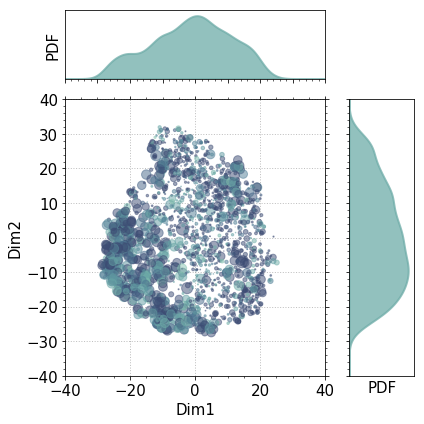

Larger data point indicates larger chi-square 
 
Color indicates the brightness of each source (blue: bright, green: faint)


In [333]:
LogRedChiSq_train = np.log10(RedChiSq_train)

gs = grs.GridSpec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4))
plt.figure(figsize=(6, 6))
ax = [plt.subplot(gs[1, 0]), plt.subplot(gs[1, 1]), plt.subplot(gs[0, 0]), plt.subplot(gs[0,1])]

ax[0].grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
ax[0].tick_params(which="both", top=True, right=True)
ax[0].minorticks_on()
ax[0].set_axisbelow(True)
ax[0].scatter(X_reduced_train[:, 0], X_reduced_train[:, 1], alpha=0.5, 
              s=LogRedChiSq_train*50, 
              color=cmap(c_scale))
ax[0].set_xlim(xlims); ax[0].set_ylim(ylims)
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('Dim1', fontsize=15)
ax[0].set_ylabel('Dim2', fontsize=15)

n = (np.linspace(ylims[0]-5, ylims[1]+5,200))
kde_X = stats.gaussian_kde(X)
kde_Y = stats.gaussian_kde(Y)
ax[1].fill_betweenx(n, kde_Y(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[1].set_ylim(ylims)
ax[1].set_xlim(0, 1.1*np.max(kde_Y(n)))
ax[1].set_xlabel('PDF', fontsize=15)
ax[1].set_xticklabels( () )
ax[1].set_yticklabels( () )
ax[1].set_xticks([])
ax[1].minorticks_on()

n = (np.linspace(xlims[0]-5, xlims[1]+5,200))
ax[2].fill(n, kde_X(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[2].set_xlim(xlims)
ax[2].set_ylim(0, 1.1*np.max(kde_X(n)))
ax[2].set_ylabel('PDF', fontsize=15)
ax[2].set_xticklabels( () )
ax[2].set_yticklabels( () )
ax[2].set_yticks([])
ax[2].minorticks_on()

ax[3].tick_params(labelbottom="off",bottom="off", labeltop='off', top='off')
ax[3].tick_params(labelleft="off",left="off", labelright='off', right='off')
plt.box("off")
plt.tight_layout()
plt.savefig('Catalina_train_tSNE_chi_mag.pdf', pad_inches=0.5)
plt.show()

print("""Larger data point indicates larger chi-square \n 
Color indicates the brightness of each source (blue: bright, green: faint)""")

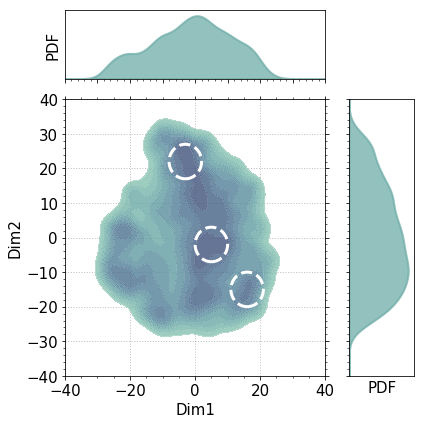

Defining; 

the left circle: region 1 
 
The right circle: region 2


In [67]:
import matplotlib.patches as patches

X, Y = X_reduced_train[:, 0], X_reduced_train[:, 1]

xlims = [-40, 40]
ylims = [-40, 40]

origin = 'lower'
levels = np.arange(0.1, 1.1, 0.1)
cmap = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

gs = grs.GridSpec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4))
plt.figure(figsize=(6, 6))
ax = [plt.subplot(gs[1, 0]), plt.subplot(gs[1, 1]), plt.subplot(gs[0, 0]), plt.subplot(gs[0,1])]

ax[0].grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
ax[0].tick_params(which="both", top=True, right=True)
ax[0].minorticks_on()
ax[0].set_axisbelow(True)
ax[0].contourf(rx, ry, rz, levels = levels,
             origin = origin,
             cmap = cmap, alpha = 0.8)
ax[0].contour(rx, ry, rz, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)
c1 = patches.Circle(xy=(5, -2), radius=5, ec='white', linewidth=3, ls='dashed', fill=False)
c2 = patches.Circle(xy=(-3, 22), radius=5, ec='white', linewidth=3, ls='dashed', fill=False)
c3 = patches.Circle(xy=(16, -15), radius=5, ec='white', linewidth=3, ls='dashed', fill=False)
ax[0].add_patch(c1); ax[0].add_patch(c2); ax[0].add_patch(c3)
ax[0].set_xlim(xlims); ax[0].set_ylim(ylims)
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('Dim1', fontsize=15)
ax[0].set_ylabel('Dim2', fontsize=15)

n = (np.linspace(ylims[0]-5, ylims[1]+5,200))
kde_X = stats.gaussian_kde(X)
kde_Y = stats.gaussian_kde(Y)
ax[1].fill_betweenx(n, kde_Y(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[1].set_ylim(ylims)
ax[1].set_xlim(0, 1.1*np.max(kde_Y(n)))
ax[1].set_xlabel('PDF', fontsize=15)
ax[1].set_xticklabels( () )
ax[1].set_yticklabels( () )
ax[1].set_xticks([])
ax[1].minorticks_on()

n = (np.linspace(xlims[0]-5, xlims[1]+5,200))
ax[2].fill(n, kde_X(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[2].set_xlim(xlims)
ax[2].set_ylim(0, 1.1*np.max(kde_X(n)))
ax[2].set_ylabel('PDF', fontsize=15)
ax[2].set_xticklabels( () )
ax[2].set_yticklabels( () )
ax[2].set_yticks([])
ax[2].minorticks_on()

ax[3].tick_params(labelbottom="off",bottom="off", labeltop='off', top='off')
ax[3].tick_params(labelleft="off",left="off", labelright='off', right='off')
plt.box("off")
plt.tight_layout()
plt.savefig('Catalina_train_tSNE.pdf', pad_inches=0.5)
plt.show()

print("""Defining; \n
the left circle: region 1 \n 
The right circle: region 2""")

In [72]:
o1 = (5, -2)
o2 = (-3, 22)
o3 = (-16, -15)
rad1 = 2
rad2 = 2
rad3 = 2
reg1_mask = np.sqrt((X_reduced_train[:,0] - o1[0])**2 + (X_reduced_train[:,1] - o1[1])**2) < rad1
reg2_mask = np.sqrt((X_reduced_train[:,0] - o2[0])**2 + (X_reduced_train[:,1] - o2[1])**2) < rad2
reg3_mask = np.sqrt((X_reduced_train[:,0] - o3[0])**2 + (X_reduced_train[:,1] - o3[1])**2) < rad3
np.sum(reg1_mask), np.sum(reg2_mask), np.sum(reg3_mask)

(27, 25, 20)

### Examples of the light curve and features in the region 1

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


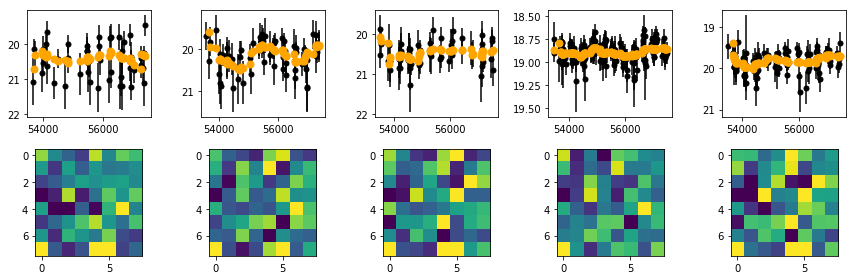

In [76]:
X, means, scales, errors, wrong_units = preprocess(X_raw)
i = 0
k=0
reg_mask = reg1_mask
plt.figure(figsize=(12, 4))
for num in range(i,i+5):
    plt.subplot(2, 5, k+1)
    plt.errorbar(X_raw_train[reg_mask][num][:,0], X_raw_train[reg_mask][num][:,1], 
                 yerr=X_raw_train[reg_mask][num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(np.cumsum(X_train[reg_mask][num][:, 0][X_train[reg_mask][num][:, 0]>0])+X_raw_train[reg_mask][num][0,0], 
             decoding_train[reg_mask][num][X_train[reg_mask][num][:, 0]>0]*scales_train[reg_mask][num]+means_train[reg_mask][num], 
                 fmt='o', color='orange', ms=7)
    plt.ylim(plt.ylim()[::-1])
    #print(np.array(RedChiSq_train)[reg_mask][num])
    k += 1
plt.tight_layout()
k=0
for num in range(i,i+5):
    plt.subplot(2, 5, k+1+5)
    plt.imshow(encoding_train[reg_mask][num].reshape(8,8), vmin=-1, vmax=1)
    k += 1
#plt.colorbar()
plt.tight_layout()
plt.savefig('Catalina_LC_region1_example.pdf', pad_inches=0.5)

### Examples of the light curve and features in the region 2

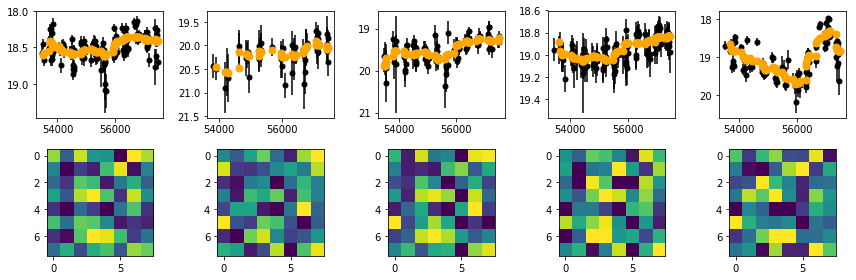

In [77]:
i = 0
k=0
reg_mask = reg2_mask
plt.figure(figsize=(12, 4))
for num in range(i,i+5):
    plt.subplot(2, 5, k+1)
    plt.errorbar(X_raw_train[reg_mask][num][:,0], X_raw_train[reg_mask][num][:,1], 
                 yerr=X_raw_train[reg_mask][num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(np.cumsum(X_train[reg_mask][num][:, 0][X_train[reg_mask][num][:, 0]>0])+X_raw_train[reg_mask][num][0,0], 
             decoding_train[reg_mask][num][X_train[reg_mask][num][:, 0]>0]*scales_train[reg_mask][num]+means_train[reg_mask][num], 
                 fmt='o', color='orange', ms=7)
    plt.ylim(plt.ylim()[::-1])
    #print(np.array(RedChiSq_train)[reg_mask][num])
    k += 1
plt.tight_layout()
k=0
for num in range(i,i+5):
    plt.subplot(2, 5, k+1+5)
    plt.imshow(encoding_train[reg_mask][num].reshape(8,8), vmin=-1, vmax=1)
    k += 1
#plt.colorbar()
plt.tight_layout()
plt.savefig('Catalina_LC_region2_example.pdf', pad_inches=0.5)

The difference between the region 1 and the region 2 mainly comes from $\Delta t$??

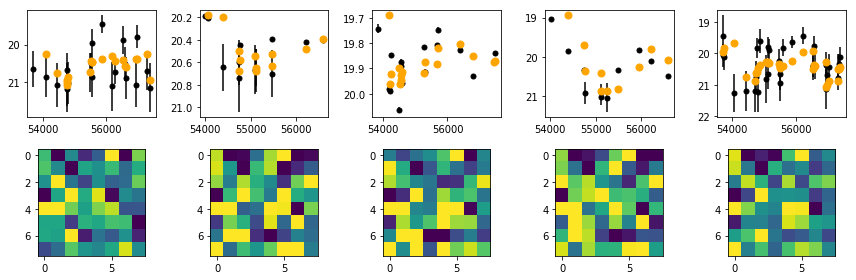

In [78]:
i = 0
k=0
reg_mask = reg3_mask
plt.figure(figsize=(12, 4))
for num in range(i,i+5):
    plt.subplot(2, 5, k+1)
    plt.errorbar(X_raw_train[reg_mask][num][:,0], X_raw_train[reg_mask][num][:,1], 
                 yerr=X_raw_train[reg_mask][num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(np.cumsum(X_train[reg_mask][num][:, 0][X_train[reg_mask][num][:, 0]>0])+X_raw_train[reg_mask][num][0,0], 
             decoding_train[reg_mask][num][X_train[reg_mask][num][:, 0]>0]*scales_train[reg_mask][num]+means_train[reg_mask][num], 
                 fmt='o', color='orange', ms=7)
    plt.ylim(plt.ylim()[::-1])
    #print(np.array(RedChiSq_train)[reg_mask][num])
    k += 1
plt.tight_layout()
k=0
for num in range(i,i+5):
    plt.subplot(2, 5, k+1+5)
    plt.imshow(encoding_train[reg_mask][num].reshape(8,8), vmin=-1, vmax=1)
    k += 1
#plt.colorbar()
plt.tight_layout()
plt.savefig('Catalina_LC_region3_example.pdf', pad_inches=0.5)

## Example of sources showing a large $\chi_{\rm red}^2$

In [81]:
len_list = []
for i in range(0,len(X_list)):
    len_list.append(len(X_list[i]))

In [89]:
chi_mask = np.array(RedChiSq) > 10

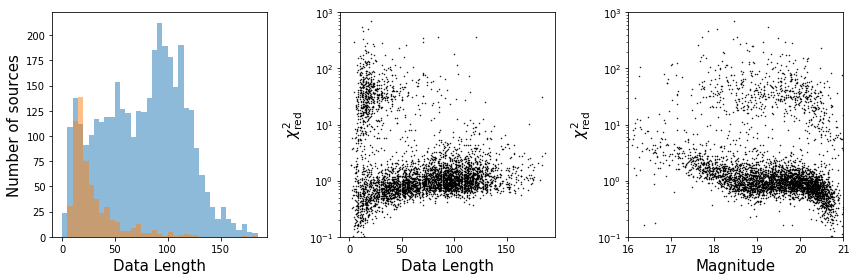

In [225]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.hist(np.array(len_list)[~chi_mask], bins=np.arange(0, 190, 5), alpha=0.5)
plt.hist(np.array(len_list)[chi_mask], bins=np.arange(0, 190, 5), alpha=0.5)
plt.xlabel('Data Length', fontsize=15)
plt.ylabel('Number of sources', fontsize=15)
plt.subplot(1,3,2)
plt.scatter(len_list, RedChiSq, alpha=1, s=0.25, color='black')
plt.xlabel('Data Length', fontsize=15)
plt.ylabel(r'$\chi_{{\rm red}}^2$', fontsize=15)
plt.ylim(1e-1, 1e3)
plt.yscale('log')
plt.subplot(1,3,3)
plt.scatter(np.nanmean(X_raw[:, :, 1], axis=1), RedChiSq, alpha=1, s=0.25, color='black')
plt.xlabel('Magnitude', fontsize=15)
plt.ylabel(r'$\chi_{{\rm red}}^2$', fontsize=15)
plt.ylim(1e-1, 1e3);plt.xlim(16, 21)
plt.yscale('log')
plt.tight_layout()
plt.show()

In [139]:
len_mask = np.array(len_list)>68

In [214]:
X_list_org = load_lcs('./lcs/')
command = 'ls ' + str('./lcs/')
lc_files = subprocess.run(command, stdout=subprocess.PIPE, shell=True).stdout.decode('utf-8').split('\n')

Loading 4227 data:
Finish.


In [215]:
bad_fitting_mask = len_mask&chi_mask

In [216]:
bad_fitting_lc_id = []
for i in range(0,np.sum(bad_fitting_mask)):
    val_top = X_raw[bad_fitting_mask][i][0]
    for j in range(0,len(X_list)):
        if np.sum(val_top == X_list_org[j][0])==3:
            bad_fitting_lc_id.append(lc_files[j])

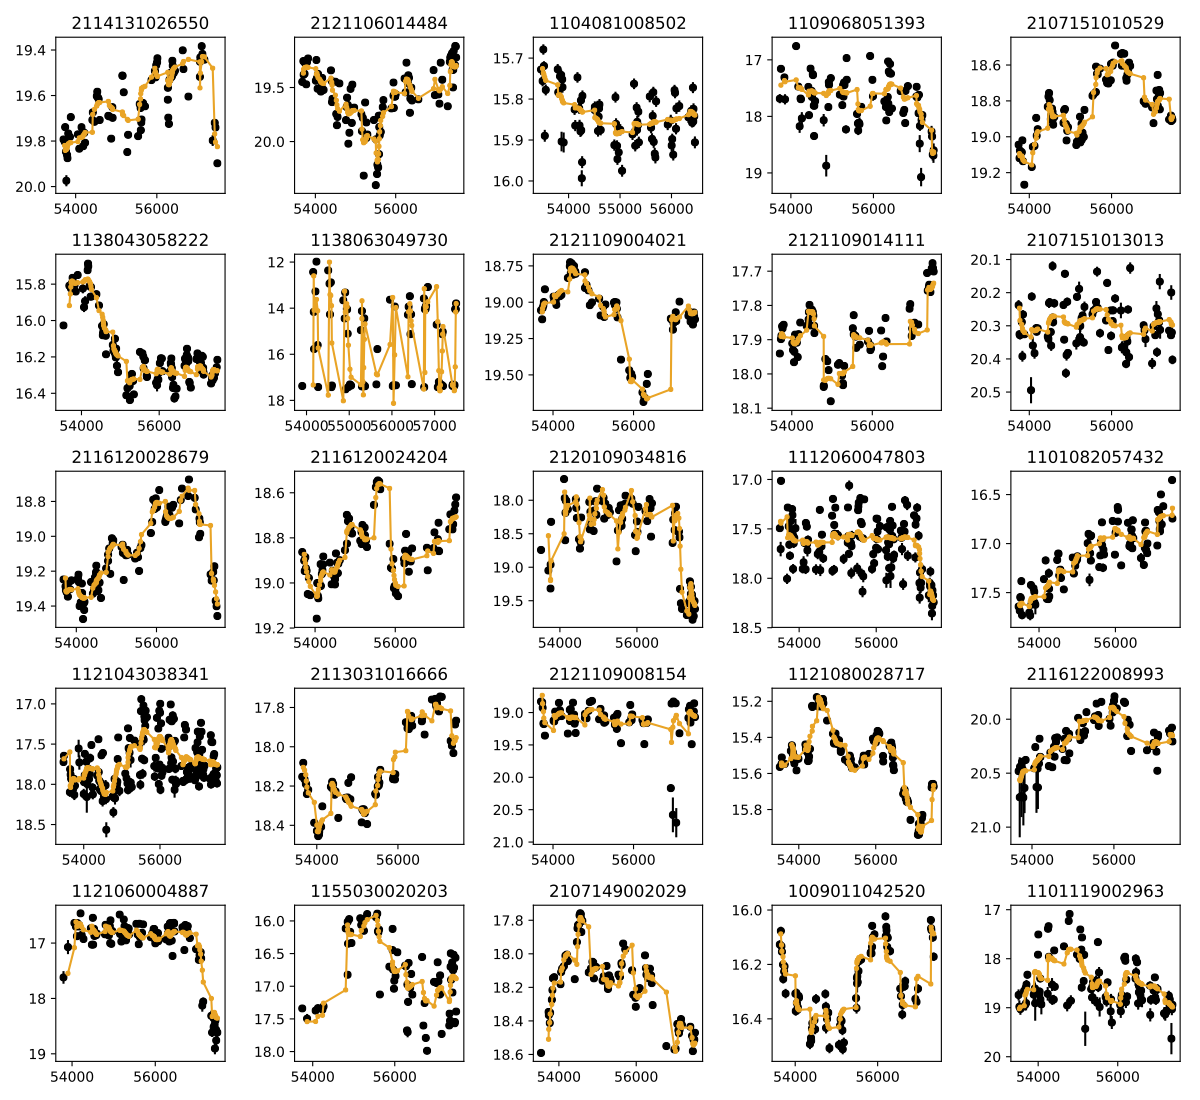

In [240]:
display_png(Image('./Catalina_LC_bad_fitting_example1.png'))

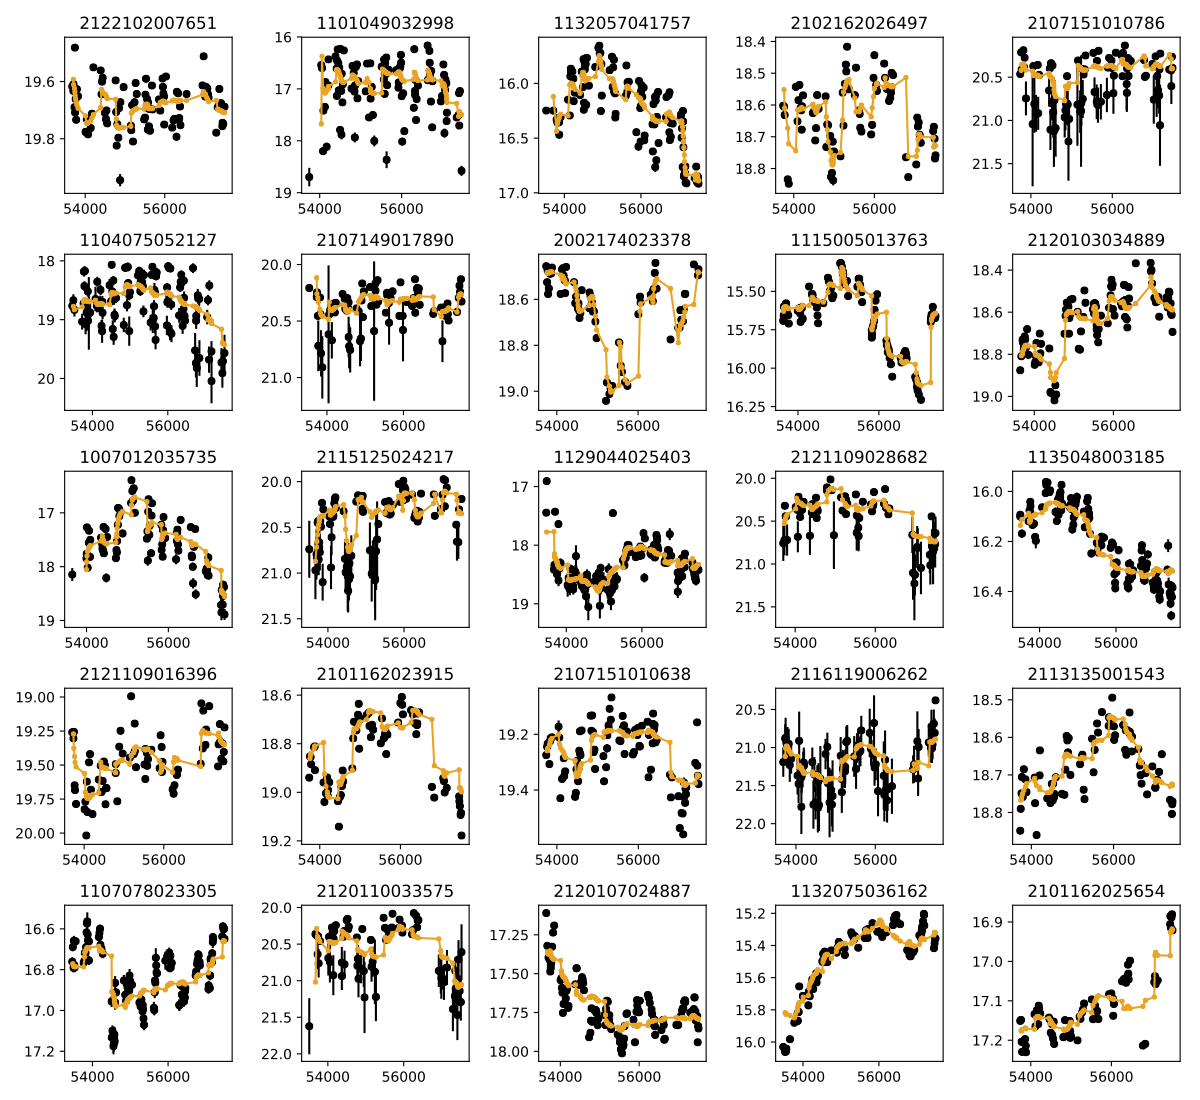

In [241]:
display_png(Image('./Catalina_LC_bad_fitting_example2.png'))

## Example of sources showing a small $\chi_{\rm red}^2$

In [244]:
chi_good_mask = np.array(RedChiSq) < 1.2

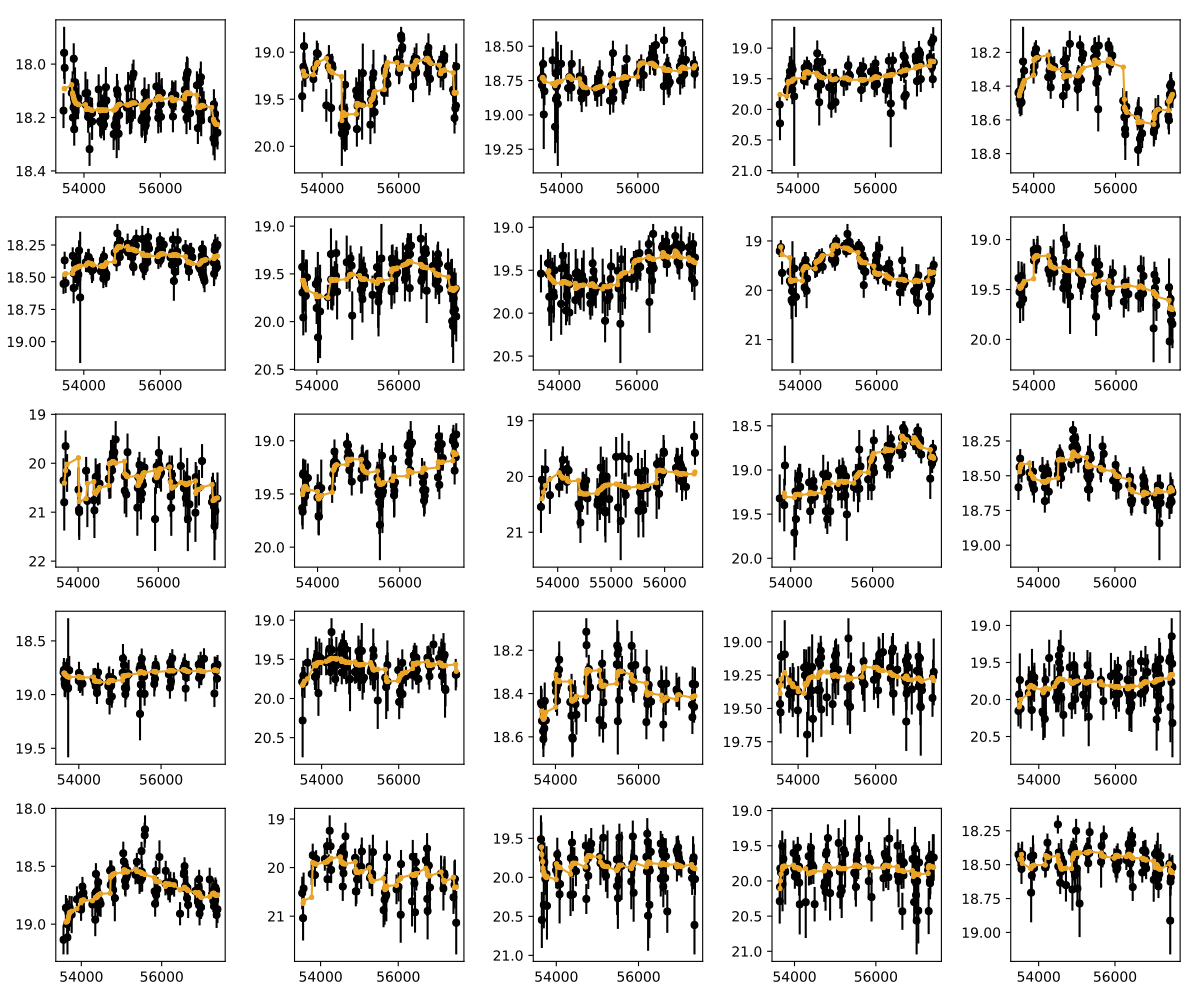

In [242]:
display_png(Image('./Catalina_LC_good_fitting_example1.png'))

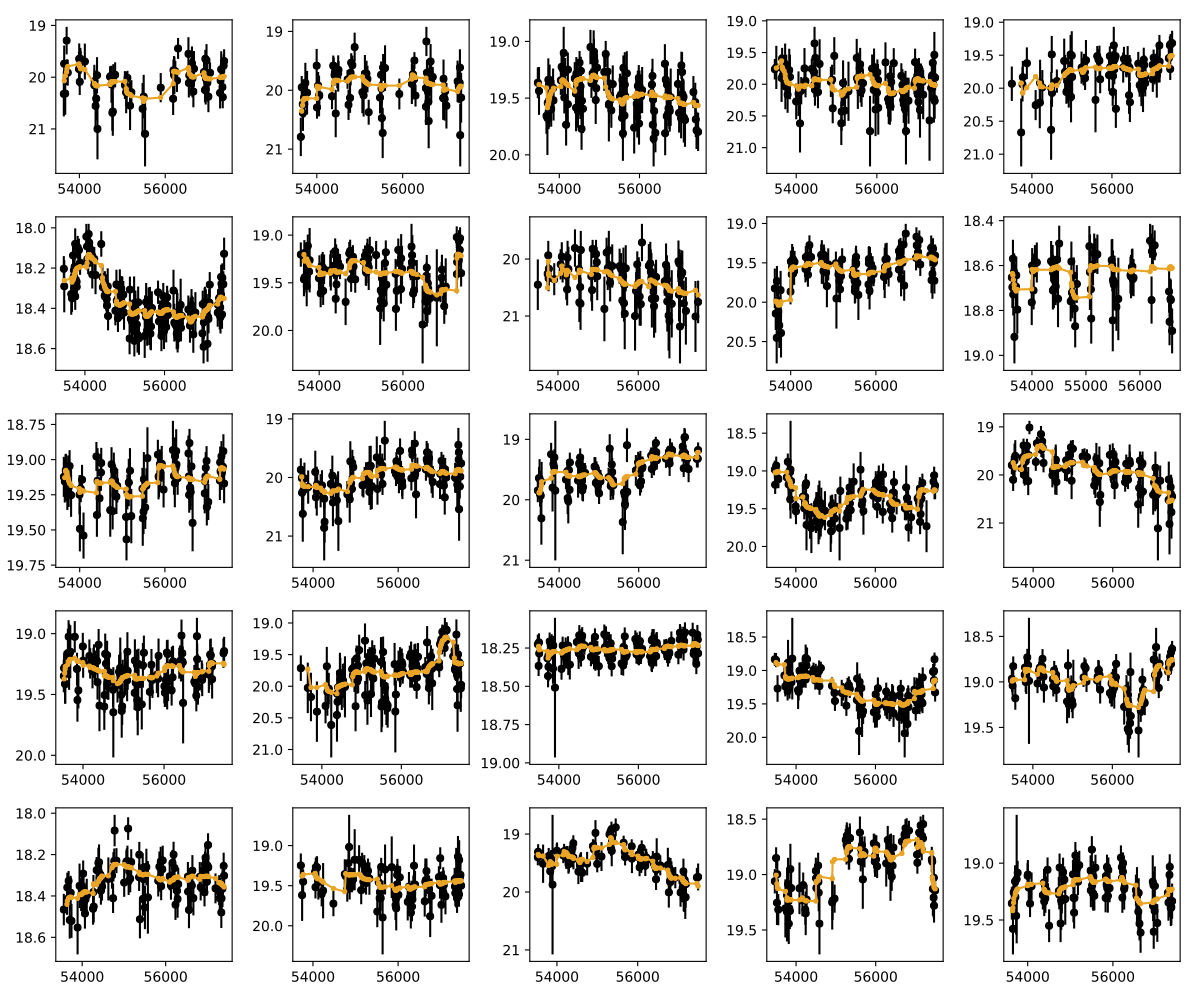

In [243]:
display_png(Image('./Catalina_LC_good_fitting_example2.png'))

In [249]:
df = pd.DataFrame(encoding)

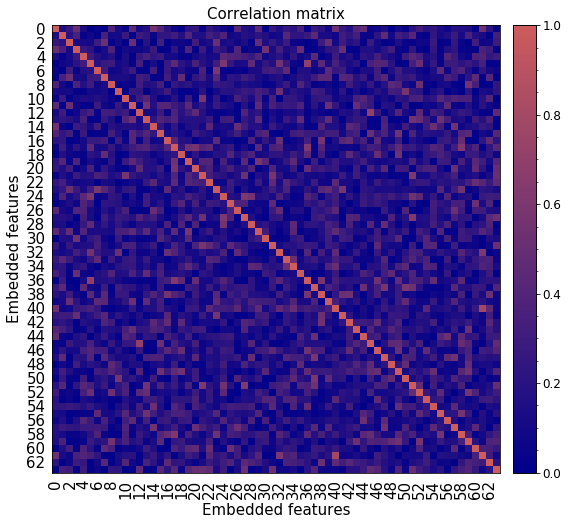

In [276]:
import mpl_toolkits.axes_grid1
from matplotlib.colors import LinearSegmentedColormap

def generate_cmap(colors):
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

cm = generate_cmap(['darkblue', 'indianred'])


def correlation_matrix(df):

    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111)
    ax1.tick_params(bottom="off", left='off')
    cmap = cm
    cax = ax1.imshow(np.abs(df.corr()), interpolation="nearest", cmap=cmap, vmin=0, vmax=1)
    #ax1.grid(True)
    plt.title('Correlation matrix', fontsize=15)
    plt.xlabel('Embedded features', fontsize=15)
    plt.ylabel('Embedded features', fontsize=15)
    labels=np.arange(0, len(df.T[0]), 2)
    ax1.set_xticks(np.arange(0, len(df.T[0]), 2))
    ax1.set_yticks(np.arange(0, len(df.T[0]), 2))
    ax1.set_xticklabels(labels,fontsize=15, rotation =90)
    ax1.set_yticklabels(labels,fontsize=15)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax1)
    cax_ = divider.append_axes('right', '5%', pad='3%')
    plt.colorbar(cax, ticks=np.arange(-1, 1.25, 0.2), cax=cax_).ax.tick_params(labelsize=12)
    plt.colorbar(cax, ticks=np.arange(-1, 1.25, 0.2), cax=cax_).ax.minorticks_on()
    plt.tight_layout()

correlation_matrix(df)
plt.savefig('CorrelationMatrix_64features.pdf', pad_inches=0.5)

In [284]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [409]:
Catalina_linkage_result = linkage(df, method='ward', metric='euclidean')

In [438]:
threshold = 0.75 * np.max(Catalina_linkage_result[:, 2])

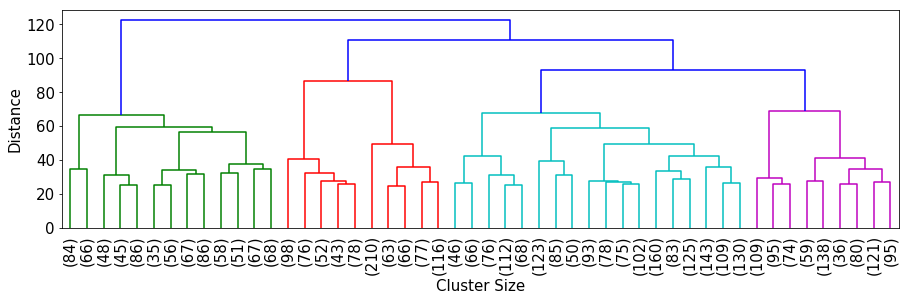

In [457]:
plt.figure(num=None, figsize=(15, 4), facecolor='w', edgecolor='k')
dendrogram(Catalina_linkage_result, color_threshold=threshold, truncate_mode='lastp', p=50)
plt.tick_params(labelsize = 15)
plt.xlabel('Cluster Size', fontsize=15)
plt.ylabel('Distance', fontsize=15)
plt.show()

In [440]:
Catalina_clustered = fcluster(Catalina_linkage_result, threshold, criterion='distance')

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


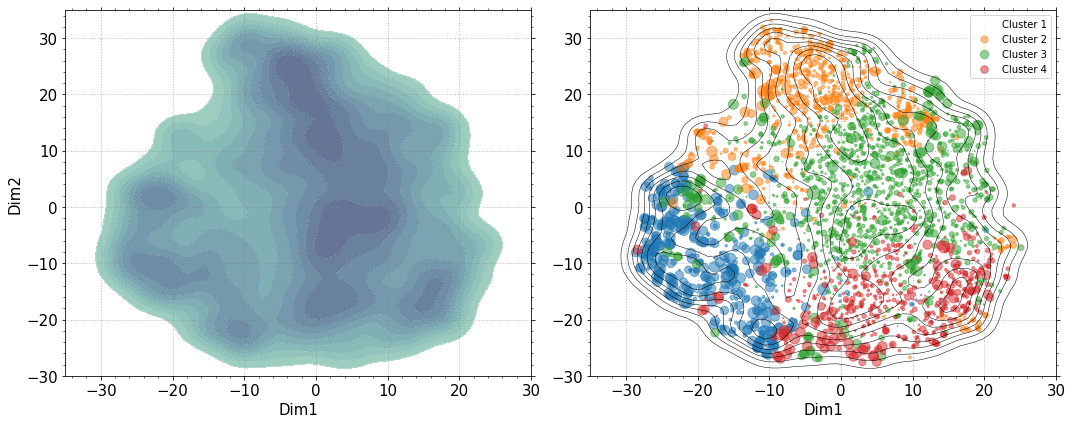

In [455]:
xlims = [-35, 30]
ylims = [-30, 35]

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)

plt.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
plt.tick_params(which="both", top=True, right=True)
plt.minorticks_on()
plt.contourf(rx, ry, rz, levels = levels,
             origin = origin,
             cmap = cmap, alpha = 0.8)
plt.contour(rx, ry, rz, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)
plt.xlim(xlims); plt.ylim(ylims)
plt.tick_params(labelsize = 15)
plt.xlabel('Dim1', fontsize=15)
plt.ylabel('Dim2', fontsize=15)

plt.subplot(1,2,2)
plt.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
plt.tick_params(which="both", top=True, right=True)
plt.minorticks_on()
plt.contour(rx, ry, rz, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("black",), alpha = 1, zorder = 11)
for cl in range(1, np.max(Catalina_clustered)+1):
    label = 'Cluster ' + str(cl)
    plt.scatter(X_reduced_train[:, 0][Catalina_clustered[0:int(0.8*len(X_list))]==cl], 
                X_reduced_train[:, 1][Catalina_clustered[0:int(0.8*len(X_list))]==cl], alpha=0.5, 
                  s=LogRedChiSq_train[Catalina_clustered[0:int(0.8*len(X_list))]==cl]*50+10, label = label)
plt.xlim(xlims); plt.ylim(ylims)
plt.tick_params(labelsize = 15)
plt.xlabel('Dim1', fontsize=15)
#plt.ylabel('Dim2', fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('Catalina_Clustered.pdf', pad_inches=0.5)